In [7]:
from edge_analyzer.acquisition import airt
from edge_analyzer import channel_waveform

duration = 0.5
sample_rate_Hz = 15.36e6
analysis_bandwidth_Hz = 10e6

print('connecting...')
capture = airt.AirTCapture(frequency_Hz=2440e6, sample_rate_Hz=sample_rate_Hz, gain_dB=0)

try:
    print('acquiring...')
    raw_iq = capture.acquire(int(duration * sample_rate_Hz))
finally:
    print('done')
    capture.close()

connecting...
acquiring...
done


In [8]:
# the following could be loaded from e.g. json

analysis_spec = {
    'power_time_series': {
        'detector_period': 10e-3,
        'detectors': ('rms', 'peak')
    },
    'cyclic_channel_power': {
        'cyclic_period': 10e-3,
        'detector_period': 1e-3 / 15 / 4,
        'detectors': ('rms', 'peak'),
        'cyclic_statistics': ('min', 'mean', 'max'),
    },
    'persistence_spectrum': {
        'window': 'flattop',
        'resolution': 15e3,
        'quantiles': [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1],
    },
    'amplitude_probability_distribution': {
        'power_low': -105,
        'power_high': -60,
        'power_count': 221,  # 0.25 dB resolution
    },
    'iq_waveform': {
        'start_time_sec': 0,
        'stop_time_sec': 100e-3
    }
}

filter_spec = {
    'ola': {
        'noverlap': 1024,
        'window': 'hamming',  # 'hamming', 'blackman', or 'blackmanharris'
    },
}

import importlib
channel_waveform = importlib.reload(channel_waveform)

dataset = channel_waveform.from_spec(
    raw_iq,
    sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    filter_spec=filter_spec,
    analysis_spec=analysis_spec,
)

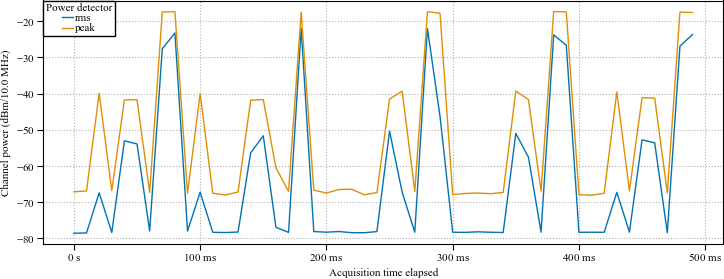

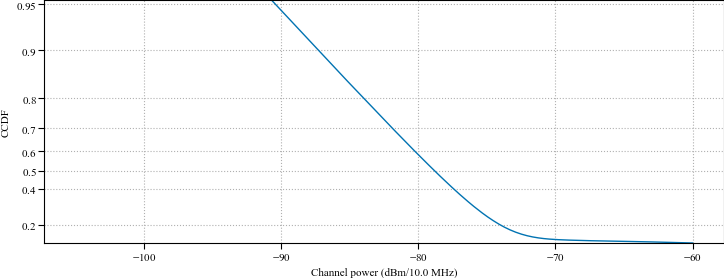

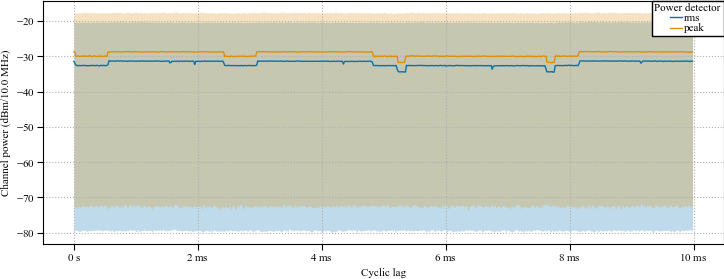

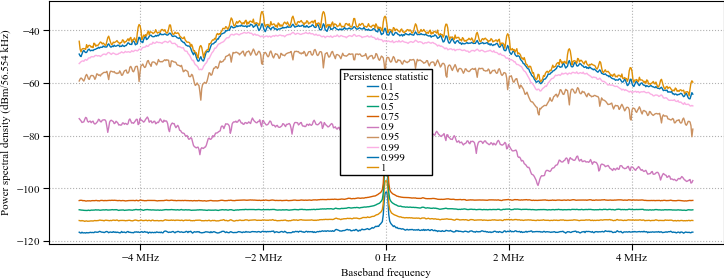

In [9]:
import iqwaveform
from edge_analyzer import figures
import matplotlib.pyplot as plt
from iqwaveform import powtodB

plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()
pvt = dataset.power_time_series
pvt.plot.line(x='time_elapsed', ax=ax)
figures.label_axis(ax.xaxis, pvt, 'time_elapsed')
figures.label_axis(ax.yaxis, pvt, tick_units=False)
figures.label_legend(ax, pvt, 'power_detector')

fig, ax = plt.subplots()
apd = dataset.amplitude_probability_distribution
apd.plot.line(x='channel_power', ax=ax)
ax.set_yscale('gamma-qq', k=1, db_ordinal=True)
figures.label_axis(ax.xaxis, apd, 'channel_power', tick_units=False)
figures.label_axis(ax.yaxis, apd)

fig, ax = plt.subplots()
cyclic_power = dataset.cyclic_channel_power
time = cyclic_power.cyclic_lag
for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)
    ax.plot(time, powtodB(a.sel(cyclic_statistic='mean')), color=f'C{i}')

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)
    ax.fill_between(
        time,
        powtodB(a.sel(cyclic_statistic='min')),
        powtodB(a.sel(cyclic_statistic='max')),
        color=f'C{i}',
        alpha=0.25,
        lw=0,
        rasterized=True,
    )

figures.label_axis(ax.xaxis, cyclic_power, 'cyclic_lag')
figures.label_axis(ax.yaxis, cyclic_power, tick_units=False)
figures.label_legend(ax, cyclic_power, 'power_detector')

fig, ax = plt.subplots()
spectrum = dataset.persistence_spectrum
spectrum.plot.line(x='baseband_frequency', ax=ax)
figures.label_axis(ax.xaxis, spectrum, 'baseband_frequency')
figures.label_axis(ax.yaxis, spectrum, tick_units=False)
figures.label_legend(ax, spectrum, 'persistence_statistic')